In [1]:
from cnn_nets import LENET, RESNET34
from custom_dataloader import load_split_train_test, uncor_selecter
from train import train_model
from federated_train_algorithms import train_fedavg_model
from pathlib import Path
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch

In [2]:
df = pd.read_excel (Path('multilabels/LandUse_Multilabeled.xlsx').resolve())
df_label = np.array(df)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names =  np.array(["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks","trees","water"])

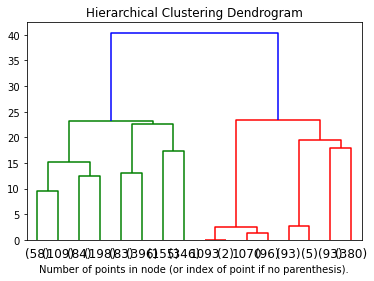

In [3]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = df_label[:,1:]

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [4]:
largestxor = 0 
largestij = (0,0)

for i in range(1,17):
    for j in range(i+1,18):
        #colnand = np.sum(np.logical_not(np.logical_and(df_label[:,i], df_label[:,j])))
        colxor = np.sum(np.logical_xor(df_label[:,i].astype(bool) , df_label[:,j].astype(bool) )) -  np.sum(np.logical_and(df_label[:,i], df_label[:,j]))
        #print(i,j, colxor, colnand)
        if colxor >= largestxor and np.sum(df_label[:,i]) >=700 and np.sum(df_label[:,j])>= 700 :
            largestxor = colxor
            largestij = (i,j)
print(largestxor,class_names[largestij[0]-1], class_names[largestij[1]-1], largestij)

674 bare-soil cars (2, 4)


In [3]:
trylist = uncor_selecter(df_label, 3, 300)
print(type(trylist), trylist)
data_dir = Path('./UCMerced_LandUse/Images').resolve()
trainloaders, valloader  = load_split_train_test(data_dir, df_label,.2)

[ 1  2  3  8 10 15] [718 691 886 975 1300 1009]
<class 'list'> [1, 2, 3]
2100
[ 1  2  3  8 10 15] [718 691 886 975 1300 1009]
549
525
606


In [4]:
model = LENET(len(class_names))

In [4]:
model = RESNET34(len(class_names))

In [5]:
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
C_FRACTION = 0.7
model = train_fedavg_model(model, device, trainloaders, valloader, optimizer_ft, criterion, exp_lr_scheduler, C_FRACTION, len(class_names), epochs=1)

Running epoch numero 0
Epoch 0/0
----------
train Loss: 0.1818 Acc: 0.1304
Training complete in 0m 2s
Done with clientelo numero whateva [[0.18178490309488204], [0.1304201680672269], [], []]
Epoch 0/0
----------
train Loss: 0.1739 Acc: 0.1196
Training complete in 0m 2s
Done with clientelo numero whateva [[0.17393385821864718], [0.11955182072829125], [], []]
Epoch 0/0
----------
train Loss: 0.2012 Acc: 0.1357
Training complete in 0m 2s
Done with clientelo numero whateva [[0.20119325785409836], [0.13574229691876744], [], []]
Epoch 0/0
----------
val Loss: 0.1391 Acc: 0.0980
Training complete in 0m 1s
Done with validation [[], [], [0.1391283679008484], [0.09801120448179267]]
